In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score
from src.model_selection import test_model
from sklearn.metrics import confusion_matrix, mean_squared_error
from scipy.stats import pearsonr

In [2]:
col_names = pd.read_csv("communities_names.csv", header = None)
list_of_column_names = []

for index, row_data in col_names.iterrows():
    list_of_column_names.append(str(row_data[0]))

df = pd.read_csv("communities_data.csv", names = list_of_column_names)

In [3]:
target = "ViolentCrimesPerPop"

In [4]:
display(df.head())
df.head()[target]

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


0    0.20
1    0.67
2    0.43
3    0.12
4    0.03
Name: ViolentCrimesPerPop, dtype: float64

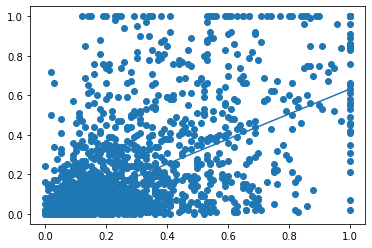

In [5]:
plt.scatter(df[target], df["racepctblack"])
c, p = pearsonr(df[target], df["racepctblack"])
plt.plot([0,c])

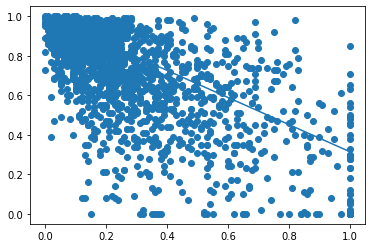

In [6]:
plt.scatter(df[target], df["racePctWhite"])
c, p = pearsonr(df[target], df["racePctWhite"])
plt.plot([1,1+c])

In [17]:
from src.processing import import_data
from src.model_selection import test_model

In [18]:
data_init, data_full, data, data_protected, data_y = import_data()

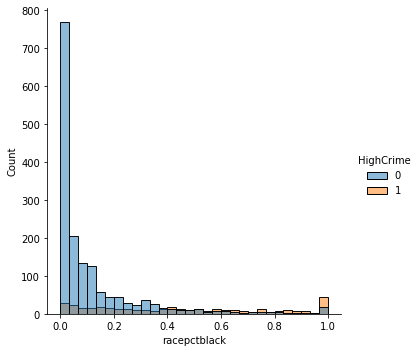

In [19]:
sns.displot(data=data_full, x="racepctblack", hue="HighCrime")

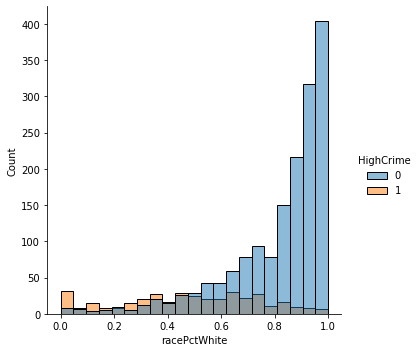

In [20]:
sns.displot(data=data_full, x="racePctWhite", hue="HighCrime")

# Testing test model with Logistig regression on high crimerate

In [21]:
def scaling_func(scaling_obj):
    def scale(x_train, x_test):
        scaler = scaling_obj().fit(x_train)
        return scaler.transform(x_train), scaler.transform(x_test)
    return scale

In [22]:
X, y = data, data_y["HighCrime"]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scaler = scaling_func(preprocessing.StandardScaler)

model = LogisticRegression
model_params = {"random_state":1, "max_iter":500}

preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

# Evaluation system
## How to calculate equalized odds

Recall and precision deffs https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124

The two elements of equalized odds

$tp / (tp+fn)$ # recall

$fp/(tn+fp)$ # false positive ratio


``` python

def calc_recall(tp,fn):
    """
    True positive rate (TPR, also called sensitivity) 
    """
    return tp/(tp+fn)
def calc_fpr(tn,fp):
    """
    False positive rate (also known as fall-out or false alarm ratio) 
    """
    return fp/(tn+fp)

def equalized_odds(y_true, y_pred):
    tn, fp, fn, tp  = confusion_matrix(y_true, y_pred).ravel()
    recall = calc_recall(tp,fn)
    fpr = calc_fpr(tn,fp)
    return recall, fpr

```

In [23]:
from src.metrics import equalized_odds

In [24]:
IsBlack = data_full.IsBlack == 1

In [25]:
IsWhite = data_full.racePctWhite >= 0.75

### Equalized odds regarding black ratio

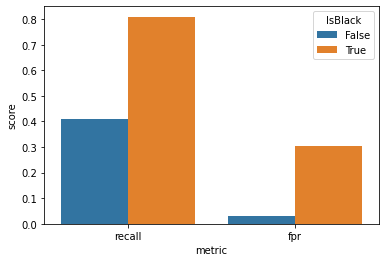

In [26]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [28]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1620
           1       0.75      0.62      0.68       374

    accuracy                           0.89      1994
   macro avg       0.83      0.78      0.80      1994
weighted avg       0.88      0.89      0.88      1994



In [29]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.7679738562091504

In [30]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.9105450236966824

In [31]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(194, 191.0)

In [32]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(180, 119.0)

# Debias data

In [33]:
from src.debias_data import debais_data

In [34]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [35]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [36]:
# Initialize the scaling and debiasing function
l_value = 0.05
scaler = debais_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

model = LogisticRegression
model_params = {"random_state":1, "max_iter":500}

preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

### Equalized odds regarding black ratio with unbias data

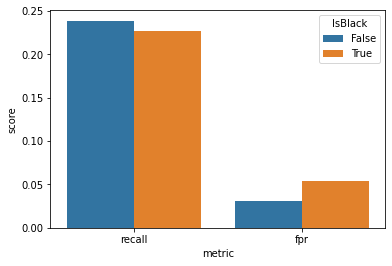

In [38]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [40]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1620
           1       0.62      0.23      0.34       374

    accuracy                           0.83      1994
   macro avg       0.73      0.60      0.62      1994
weighted avg       0.80      0.83      0.80      1994



In [41]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.49019607843137253

In [42]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.8909952606635071

In [43]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(194, 50.0)

In [44]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(180, 90.0)

# Berk linear constraint model

In [45]:
from src.linear_models import BerkFairLogreg

In [46]:
def scaling_func(scaling_obj):
    def scale(x_train, x_test):
        scaler = scaling_obj().fit(x_train)
        return scaler.transform(x_train), scaler.transform(x_test)
    return scale

In [47]:
protected_col = "IsBlack"
berk_data = data.copy()
berk_data["interception"] = np.ones(len(data))
berk_data[protected_col] = data_full[protected_col]
assert berk_data.columns[-1] == protected_col, f"The last data must be the protected column, i.e. {protected_col}"

X, y = berk_data, data_y["HighCrime"].values

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scaler = scaling_func(preprocessing.StandardScaler)

model = BerkFairLogreg
model_params = {"lambda_":1, "gamma_":0.001}

preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   1.16811864E+00
tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599450E-01   1.16811864E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)


The model end state is 1 which is good


  NIT   NF   F                       GTG
    0    1  6.931471805599448E-01   1.10524928E+00


The model end state is 1 which is good


tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599448E-01   1.10524928E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   1.09110498E+00


The model end state is 1 which is good


tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599450E-01   1.09110498E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   1.05104556E+00
tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599450E-01   1.05104556E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)


The model end state is 1 which is good


  NIT   NF   F                       GTG
    0    1  6.931471805599448E-01   1.02614543E+00
tnc: |fn-fn-1] = 0 -> convergence
    1   53  6.931471805599448E-01   1.02614543E+00
tnc: Converged (|f_n-f_(n-1)| ~= 0)


The model end state is 1 which is good


In [48]:
yhat = preds
preds = np.array([1 if x > 0 else 0 for x in preds])

In [49]:
preds.mean()

0.41223671013039115

### Equalized odds regarding black ratio with unbias data

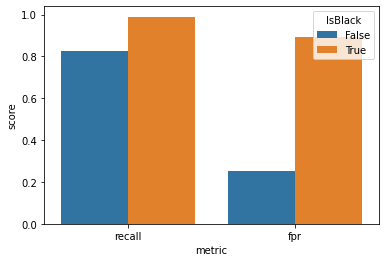

In [50]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
tmp_df = pd.concat([tmp_df_1, tmp_df_2])

sns.barplot(data=tmp_df, x="metric", y="score", hue="IsBlack")
plt.show()

In [52]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.97      0.70      0.82      1620
           1       0.41      0.91      0.57       374

    accuracy                           0.74      1994
   macro avg       0.69      0.81      0.69      1994
weighted avg       0.87      0.74      0.77      1994



In [53]:
accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])

0.6666666666666666

In [54]:
accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])

0.7559241706161137

In [55]:
np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])

(194, 292)

In [56]:
np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])

(180, 530)